In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import matplotlib.pyplot as plt


In [15]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        # img_dim: 784
        super().__init__()

        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        # z_dim: dimension of the latent noise that the generator will take as input
        # img_dim: 784
        super().__init__()

        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh(), # Because the mnist will be normalized to 0 and 1 so we nedd output between 0 and 1.
        )

    def forward(self, x):
        return self.gen(x)



In [17]:

#! Hyper Parameters.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4 # suggested by andrej karpathy for adam
z_dim = 128 # can be anything
image_dim = 28*28*1 # 784
batch_size = 32 # standard
num_epochs = 50

disc = Discriminator(image_dim).to(device=device)
gen = Generator(z_dim, image_dim).to(device=device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device=device) # fixed coz we will see how's it changes during epochs.
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()


In [18]:
## Training

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ## Train Discriminator: maximize log(D(real)) + log(1- D(G(z))) where z is random noise
        noise = torch.randn((batch_size, z_dim)).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ## Train Generator: min log(1 - D(G(z)) <-> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(f"Epoch[{epoch}/{num_epochs}] \ "
                  f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
                  )

Epoch[0/50] \ Loss D: 0.7759, Loss G: 0.7268
Epoch[1/50] \ Loss D: 0.2136, Loss G: 1.8330
Epoch[2/50] \ Loss D: 0.5253, Loss G: 1.0823
Epoch[3/50] \ Loss D: 0.6482, Loss G: 0.8659
Epoch[4/50] \ Loss D: 0.8456, Loss G: 0.9383
Epoch[5/50] \ Loss D: 0.6731, Loss G: 1.2944
Epoch[6/50] \ Loss D: 0.4016, Loss G: 1.5032
Epoch[7/50] \ Loss D: 0.3630, Loss G: 1.7034
Epoch[8/50] \ Loss D: 0.3847, Loss G: 1.4730
Epoch[9/50] \ Loss D: 0.2581, Loss G: 2.5521
Epoch[10/50] \ Loss D: 0.6377, Loss G: 1.1654
Epoch[11/50] \ Loss D: 0.7144, Loss G: 0.9147
Epoch[12/50] \ Loss D: 0.6187, Loss G: 1.2938
Epoch[13/50] \ Loss D: 0.5926, Loss G: 1.5683
Epoch[14/50] \ Loss D: 0.5555, Loss G: 1.7246
Epoch[15/50] \ Loss D: 0.6589, Loss G: 1.4953
Epoch[16/50] \ Loss D: 0.6430, Loss G: 1.4519
Epoch[17/50] \ Loss D: 0.4278, Loss G: 1.5332
Epoch[18/50] \ Loss D: 0.4509, Loss G: 1.5989
Epoch[19/50] \ Loss D: 0.5043, Loss G: 2.0477
Epoch[20/50] \ Loss D: 0.5626, Loss G: 1.9080
Epoch[21/50] \ Loss D: 0.6389, Loss G: 1.475

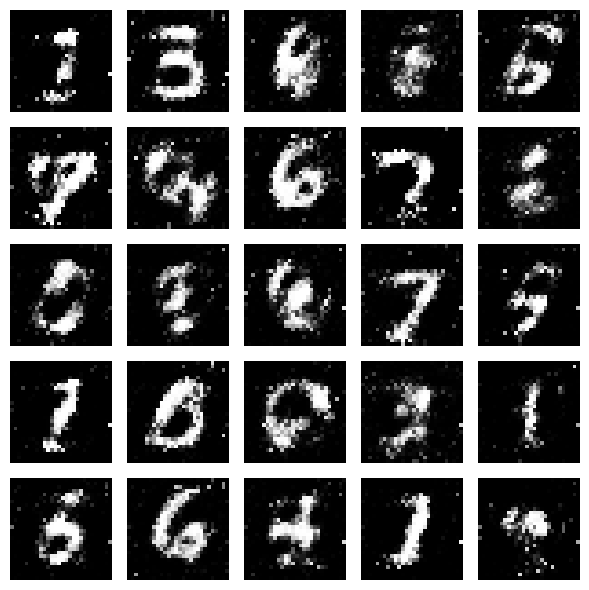

In [19]:
# Assuming the Generator model `gen` is already trained

def generate_images(generator, num_images, z_dim, device):
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():  # We don't need gradients during inference
        # Generate random noise
        noise = torch.randn(num_images, z_dim).to(device)
        # Generate fake images
        fake_images = generator(noise).reshape(-1, 1, 28, 28)
        # Denormalize images from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2
        return fake_images

# Generate images
num_images = 25  # Number of images to generate
fake_images = generate_images(gen, num_images, z_dim, device)

# Plotting the images in 3 rows and 3 columns
rows = 5
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(fake_images[i * cols + j].squeeze().cpu(), cmap="gray")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()
